In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
#read data
Changping_data_raw=pd.read_csv('PRSA_Data_Changping_20130301-20170228.csv')
Changping_data = np.array(Changping_data_raw)

#### import data as training & test sets

In [3]:
# Training set
data_pm25 = Changping_data[:,11:16] #input data
lable_pm25 = Changping_data[:,8] #output label

data_pm25 = np.array(data_pm25)
lable_pm25 = np.array(lable_pm25)

mean = data_pm25.mean(axis=0, dtype=float)
std = data_pm25.std(axis=0, dtype=float)

In [4]:
train_data = data_pm25[0:int(len(data_pm25)*0.8)]
train_label = lable_pm25[0:int(len(data_pm25)*0.8)]
test_data = data_pm25[int(len(data_pm25)*0.8):int(len(data_pm25))]
test_label = lable_pm25[int(len(data_pm25)*0.8):int(len(data_pm25))]

train_data = np.array(train_data, dtype= np.float32)
train_label = np.array(train_label, dtype= np.float32)
test_data = np.array(test_data, dtype= np.float32)
test_label = np.array(test_label, dtype= np.float32)

train_data = (train_data - mean) / std # (train_data - min) / (max-min) 
test_data = (test_data - mean) / std

order = np.argsort(np.random.random(train_label.shape))
train_data = train_data[order]
train_label = train_label[order]

print(train_data.shape,train_label.shape,test_data.shape,test_label.shape)

(1100, 5) (1100,) (275, 5) (275,)


In [5]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [6]:
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(train_data.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
#model.add(Dense(train_label.shape[0],  activation='linear')) # the output layer
model.add(Dense(1,  activation='linear')) # the output layer

model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

2022-12-22 21:09:29.030161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [8]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(train_data, train_label, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/50
14/14 [==============================] - 0s 7ms/step - loss: 4314.5225 - val_loss: 3511.6060
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 4082.4290 - val_loss: 3203.8459
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 3583.5000 - val_loss: 2573.3269
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 2663.1445 - val_loss: 1627.0129
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 1488.7953 - val_loss: 943.4128
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 906.8876 - val_loss: 783.4009
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 762.5782 - val_loss: 672.7060
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 716.2003 - val_loss: 656.8444
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 705.7009 - val_loss: 661.6074
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 

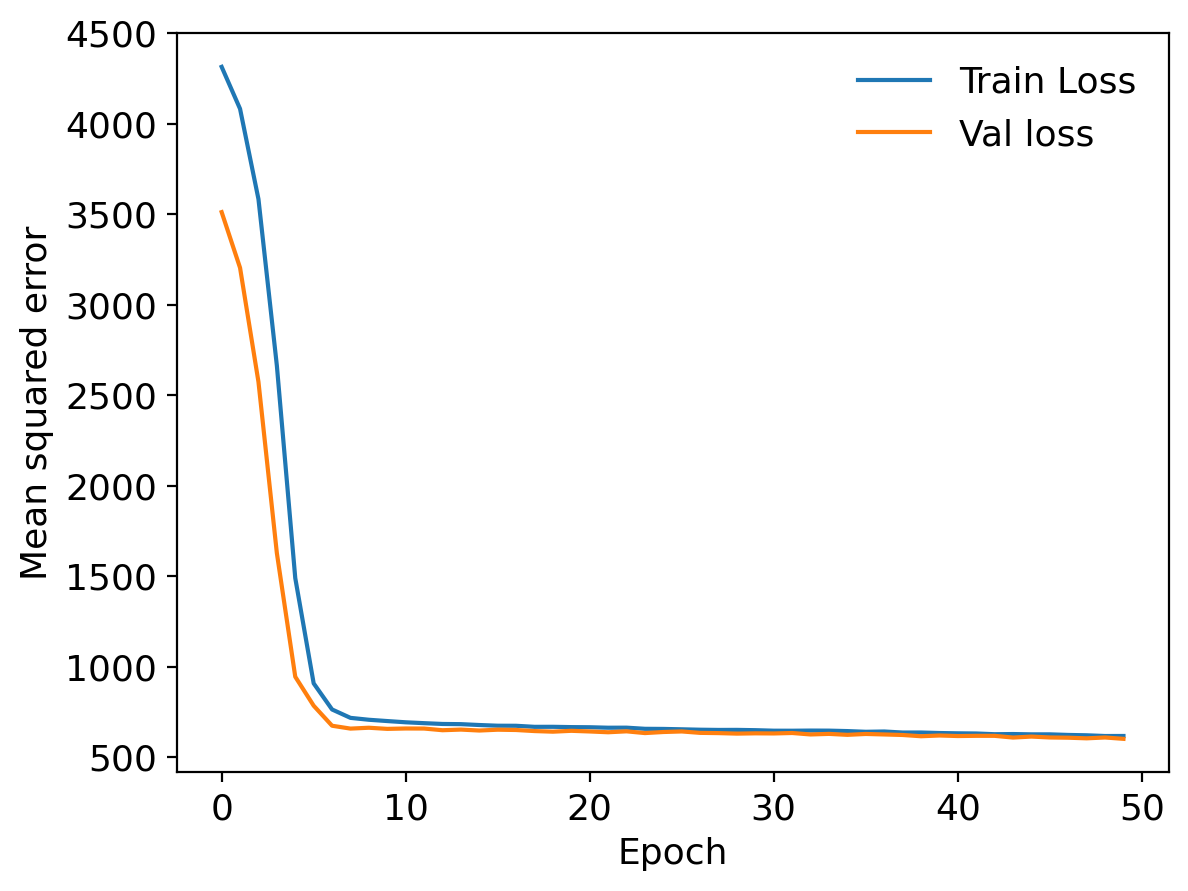

In [9]:
plot_history(history)

In [10]:
y_test_pre = model.predict(test_data)

9/9 [==============================] - 0s 611us/step


In [11]:
test_label.shape


(275,)

In [12]:
rmes=np.sqrt(np.mean((y_test_pre-test_label)**2))
rmes

42.69342